Import backtester

In [173]:
import importlib.util
import sys
import os

# Path to backtester.py
backtester_path = "backtester.py"
spec = importlib.util.spec_from_file_location("backtester", backtester_path)
backtester = importlib.util.module_from_spec(spec)
sys.modules["backtester"] = backtester
spec.loader.exec_module(backtester)

Code:

In [ ]:
"""import numpy as np
from sklearn.decomposition import PCA

RETRAIN_INTERVAL = 100
LOOKBACK_WINDOW = 200
Z_ENTRY = 1.0
INSTRUMENT_POSITION_LIMIT = 10000

model_state = {
    "last_trained": -RETRAIN_INTERVAL,
    "top_pairs": [],
    "pca_model": None
}

def compute_zscore(spread):
    mean = np.mean(spread)
    std = np.std(spread)
    return (spread - mean) / (std + 1e-6)

def get_pca_residual(p1, p2):
    X = np.vstack([p1, p2]).T
    pca = PCA(n_components=1)
    principal = pca.fit_transform(X)
    reconstructed = pca.inverse_transform(principal)
    residual = X - reconstructed
    return residual[:, 0] - residual[:, 1]

def getMyPosition(prcSoFar):
    global model_state
    if prcSoFar.shape[1] == LOOKBACK_WINDOW + 10:
        model_state = {
            "last_trained": -RETRAIN_INTERVAL,
            "top_pairs": [],
            "pca_model": None
        }

    n_assets, n_days = prcSoFar.shape
    positions = np.zeros(n_assets)

    if n_days < LOOKBACK_WINDOW + 10:
        return positions

    # Retrain every interval
    if n_days - model_state["last_trained"] >= RETRAIN_INTERVAL:
        model_state["last_trained"] = n_days

        # Compute rolling correlations
        returns = np.diff(np.log(prcSoFar[:, -LOOKBACK_WINDOW:]), axis=1)
        cor_matrix = np.corrcoef(returns)
        pairs = [((i, j), abs(cor_matrix[i, j])) for i in range(n_assets) for j in range(i+1, n_assets)]
        top_pairs = sorted(pairs, key=lambda x: -x[1])[:10]
        model_state["top_pairs"] = [pair for pair, _ in top_pairs]

        # Fit PCA to all asset prices
        X = prcSoFar[:, -LOOKBACK_WINDOW:].T
        model_state["pca_model"] = PCA(n_components=1).fit(X)

    # Trade signals for top pairs
    for i, j in model_state["top_pairs"]:
        p1, p2 = prcSoFar[i, -LOOKBACK_WINDOW:], prcSoFar[j, -LOOKBACK_WINDOW:]
        spread = p1 - p2
        z = compute_zscore(spread)

        # PCA residual
        residual = get_pca_residual(p1, p2)
        r_z = compute_zscore(residual)

        # Hybrid signal: combine spread z-score and PCA residual z-score
        hybrid_signal = z[-1] + r_z[-1]

        # Position sizing inversely proportional to volatility
        volatility = np.std(spread)
        capital = 2000 / (volatility + 1e-6)

        if hybrid_signal > Z_ENTRY:
            positions[i] -= capital / prcSoFar[i, -1]
            positions[j] += capital / prcSoFar[j, -1]
        elif hybrid_signal < -Z_ENTRY:
            positions[i] += capital / prcSoFar[i, -1]
            positions[j] -= capital / prcSoFar[j, -1]

    # Enforce position limits
    pos_limit = INSTRUMENT_POSITION_LIMIT / prcSoFar[:, -1]
    return np.clip(positions, -pos_limit, pos_limit)"""
import numpy as np
from itertools import combinations
import random

nInst = 50
currentPos = np.zeros(nInst)

# Global cache
lastComputedDay = -1
cachedTopTriplets = []

def compute_spread_zscore_triplet(prices):
    prices = np.array(prices)
    y = prices[0]
    X = prices[1:].T
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    spread = y - X.dot(beta)

    window = 30
    rolling_mean = np.array([np.mean(spread[max(0, i - window):i]) for i in range(1, len(spread) + 1)])
    rolling_std = np.array([np.std(spread[max(0, i - window):i]) for i in range(1, len(spread) + 1)])
    rolling_std[rolling_std == 0] = 1
    z = (spread - rolling_mean) / rolling_std
    return spread, z, beta

def simulate_trades_triplet(z, entry=1.0, exit=0.2):
    positions = np.zeros(len(z))
    for t in range(1, len(z)):
        if z[t - 1] < -entry:
            positions[t] = 1
        elif z[t - 1] > entry:
            positions[t] = -1
        elif abs(z[t - 1]) < exit:
            positions[t] = 0
        else:
            positions[t] = positions[t - 1]
    return positions

def get_asset_positions_from_signal(signal, beta, prices, max_dollar=10000, base_shares=1000):
    m = len(prices)
    positions = np.zeros(m, dtype=int)
    if signal == 0:
        return positions
    pos0 = base_shares if signal == 1 else -base_shares
    pos_others = -pos0 * beta if signal == 1 else pos0 * beta
    pos_others = np.round(pos_others).astype(int)
    positions[0] = pos0
    positions[1:] = pos_others
    for i in range(m):
        max_shares = int(max_dollar / prices[i])
        if abs(positions[i]) > max_shares:
            positions[i] = np.sign(positions[i]) * max_shares
    return positions

def find_top_triplets_sampled(cor_matrix, top_n=10, n_samples=1000):
    n = cor_matrix.shape[0]
    triplet_scores = []
    sampled = random.sample(list(combinations(range(n), 3)), min(n_samples, len(list(combinations(range(n), 3)))))
    for group in sampled:
        sub_corr = cor_matrix[np.ix_(group, group)]
        off_diag_sum = np.sum(np.abs(sub_corr)) - np.sum(np.abs(np.diag(sub_corr)))
        triplet_scores.append((group, off_diag_sum))
    triplet_scores.sort(key=lambda x: x[1], reverse=True)
    return triplet_scores[:top_n]

def getMyPosition(prcSoFar):
    global currentPos, lastComputedDay, cachedTopTriplets

    n_assets, n_days = prcSoFar.shape
    if n_days < 60:
        return np.zeros(n_assets, dtype=int)

    if n_days % 30 == 0 or lastComputedDay == -1:
        returns = np.diff(np.log(prcSoFar), axis=1)
        cor_matrix = np.corrcoef(returns)
        cachedTopTriplets = find_top_triplets_sampled(cor_matrix, top_n=10, n_samples=1000)
        lastComputedDay = n_days

    position_vector = np.zeros(n_assets, dtype=int)

    for triplet, _ in cachedTopTriplets:
        try:
            triplet_prices = [prcSoFar[i] for i in triplet]
            spread, z, beta = compute_spread_zscore_triplet(triplet_prices)
            signal = simulate_trades_triplet(z)[-1]
            current_prices = np.array([p[-1] for p in triplet_prices])
            group_positions = get_asset_positions_from_signal(signal, beta, current_prices)
            for idx, inst_id in enumerate(triplet):
                position_vector[inst_id] += group_positions[idx]
        except Exception:
            continue

    currentPos = position_vector
    return currentPos



Run backtester

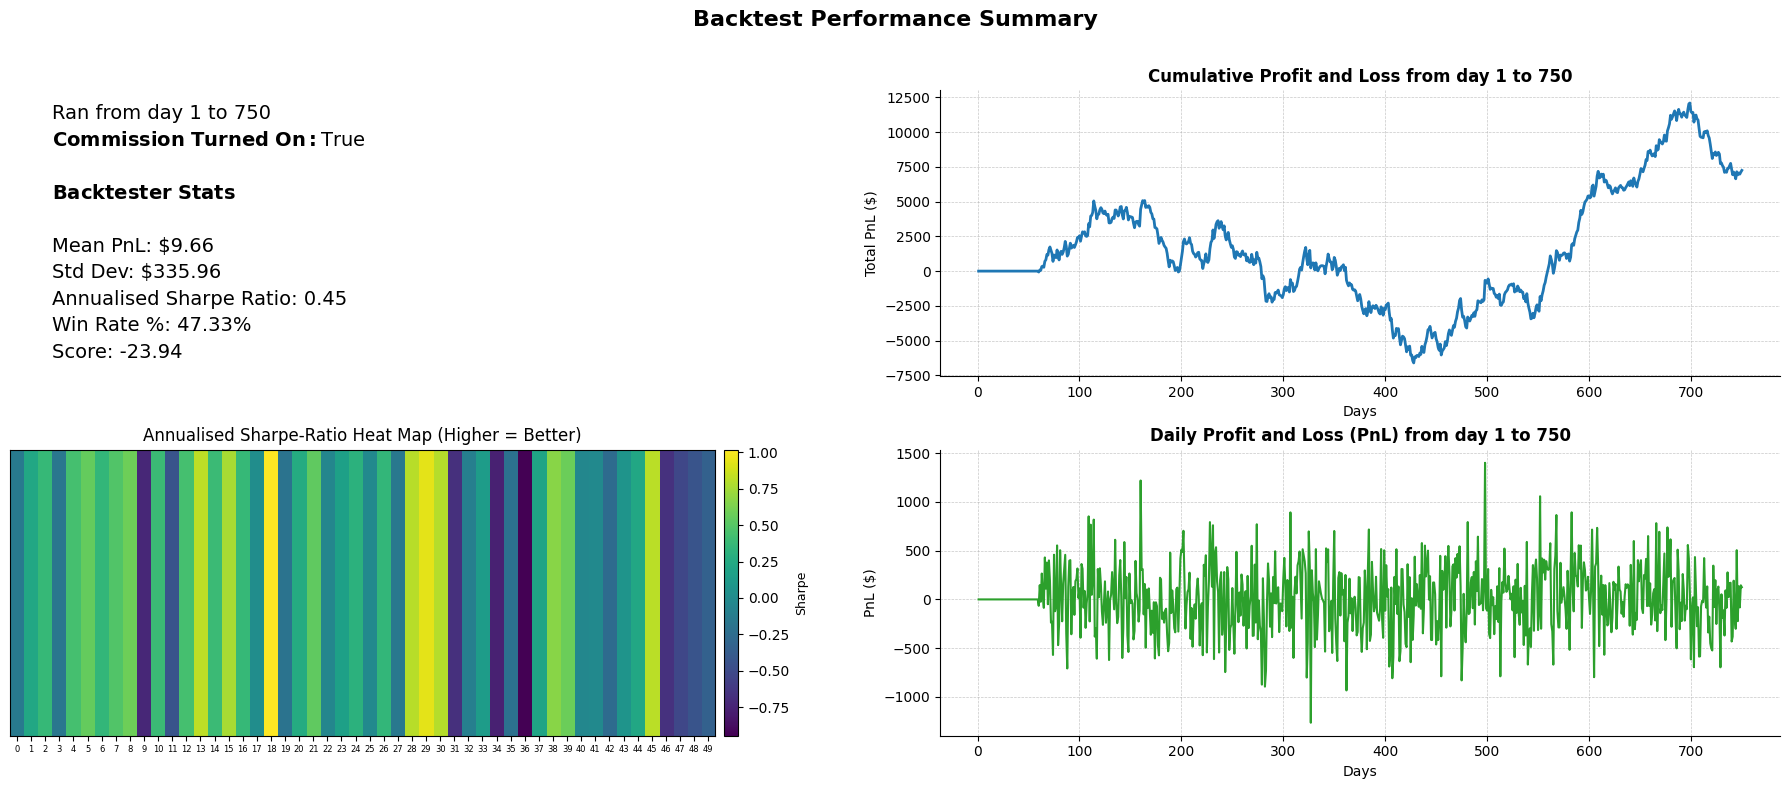

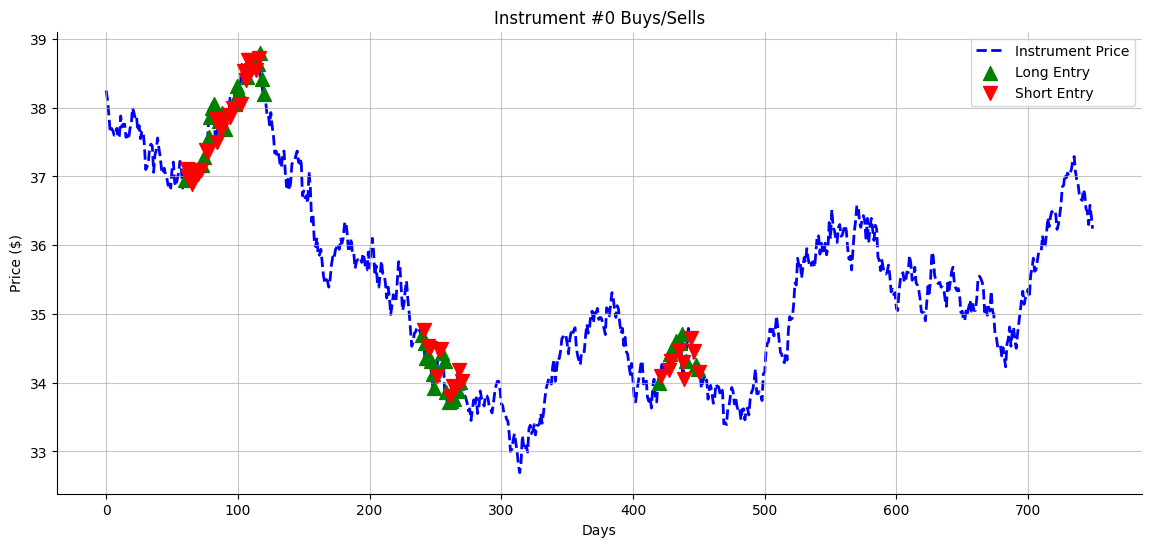

In [175]:
params = backtester.Params(
    strategy_function=getMyPosition,
    start_day=1,
    end_day=750,
    enable_commission=True,
    graphs=["cum-pnl", "sharpe-heat-map", "daily-pnl"]
)

bt = backtester.Backtester(params)
results = bt.run(start_day=1, end_day=750)
bt.show_dashboard(results, graphs=params.graphs)
bt.show_price_entries(results)